In [ ]:
!pip install datasets
#!pip install --upgrade tensorflow
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 27.9 MB/s eta 

#Image classifier

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras import layers
from keras import ops, activations, Sequential, Model
class PatchGenerator(layers.Layer):
    def __init__(self, patch_size, batch_size, **kwargs):
        super().__init__()
        self.patch_size = patch_size
        self.batch_size = batch_size

    def call(self, images):
        input_shape = ops.shape(images)
        print(input_shape)
        height = input_shape[0]
        width = input_shape[1]
        channels = input_shape[2]

        num_patches_h = height //self.patch_size
        num_patches_w = width // self.patch_size

        patches = ops.image.extract_patches(images, size=self.patch_size)

        patches = ops.reshape(
            patches,
            (self.batch_size, num_patches_h * num_patches_w, self.patch_size * self.patch_size * channels)
        )

        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size, 'batch_size': self.batch_size})
        return config


class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim = num_patches, output_dim = projection_dim)

    def call(self, patch):
        positions = ops.expand_dims(ops.arange(start=0, stop=self.num_patches, step=1), axis=0)

        projected_patches = self.projection(patch)

        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

    def get_config(self):
        return {'num_patches': self.num_patches, 'projection_dim': self.projection_dim}



class TransformerEncoder(keras.layers.Layer):
    def __init__(self, epsilon, dropout_rate, att_heads, projection_dim, **kwargs):
        super().__init__()
        self.norm1 = layers.LayerNormalization(epsilon = epsilon)
        self.attention1 = layers.MultiHeadAttention(num_heads = att_heads, key_dim = projection_dim,dropout = dropout_rate)

        self.add1 = layers.Add()

        self.norm2 = layers.LayerNormalization(epsilon=epsilon)
        self.mlp = Sequential([layers.Dense(projection_dim*2, activation = activations.gelu), layers.Dense(projection_dim)])
        self.add2 = layers.Add()

    def call(self, encoded_patches):
        o1 = self.norm1(encoded_patches)
        a1 = self.attention1(o1, o1)

        o2 = self.add1([a1, encoded_patches])
        o3 = self.norm2(o2)
        o4 = self.mlp(o3)
        o5 = self.add2([o4, o2])
        return o5
    def get_config(self):
        return {'projection_dim': self.projection_dim, 'epsilon': self.epsilon, 'dropout_rate': self.dropout_rate, 'attention_heads': self.att_heads}


#class VisionTransformer(keras.Model):
#    def __init__(self, input_dim, patch_size, patch_num, projection_dim, epsilon, dropout, att_heads, output_dim):
#        self.patch_gen = PatchGenerator(patch_size)
#        self.patch_encoder = PatchEncoder(patch_size, projection_dim)
#        self.transformer = TransformerEncoder(epsilon, dropout, att_heads, projection_dim)

class ViT(Model):
    def __init__(self, img_size, patch_size, num_patches, projection_dim, epsilon, dropout_rate, attention_heads, mlp_units, num_classes=None, **kwargs):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.epsilon = epsilon
        self.dropout_rate = dropout_rate
        self.attention_heads = attention_heads
        self.mlp_units = mlp_units
        self.num_classes = num_classes
        self.num_patches = num_patches

        self.patch_gen = PatchGenerator(patch_size, batch_size=1)
        self.patch_encoder = PatchEncoder(num_patches, projection_dim)
        self.transformer = TransformerEncoder(epsilon, dropout_rate, attention_heads, projection_dim)

        self.ln1 = layers.LayerNormalization(epsilon=1e-6)
        #(encoded_patches)
        self.fl1 = layers.Flatten()
        #(representation)
        self.drop = layers.Dropout(0.5)
        #(representation)
        self.mlp = layers.Dense(mlp_units, activation = activations.gelu)

        #(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)

        self.logits = layers.Dense(num_classes)

        #(features)


    def call(self, img):
        resized = layers.Resizing(image_size, image_size)(img)
        outputs = self.patch_gen(img)
        outputs = self.patch_encoder(outputs)

        outputs = self.transformer(outputs)
        outputs = self.ln1(outputs)
        outputs = self.fl1(outputs)
        outputs = self.drop(outputs)
        outputs = self.mlp(outputs)
        logit = self.logits(outputs)

        return logit

    def get_config(self):
        return {'img_size': self.img_size, 'patch_size': self.patch_size, 'num_patches': self.num_patches, 'projection_dim': self.projection_dim, 'epsilon': self.epsilon, 'dropout_rate': self.dropout_rate, 'attention_heads': self.attention_heads, 'mlp_units': self.mlp_units, 'num_classes': self.num_classes}


In [ ]:
!pip install datasets

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
image_size = 32  # We'll resize input images to this size
patch_size = 4 # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
attention_heads = 4
epsilon=1e-6
dropout_rate = 0.1

#patch_size=8
#image_size=32
projection_dim= 256


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow import kerat
from datasets import load_dataset
import tensorflow as tf
from keras import optimizers

print("hello workd")

train = load_dataset('uoft-cs/cifar10', split = 'train')





learning_rate=0.01
weight_decay=0.0001
batch_size=128
num_epochs=1
patch_size=8
image_size=32
projection_dim= 256
num_patches = (image_size // patch_size) ** 2
epsilon=1e-6
dropout_rate = 0.1
attention_heads=1



def data_gen(dataset):

    inputs = []
    targets = []
    unique_targets = set()

    for item in dataset:
        img = np.array(item['img'])
        if len(img.shape) == 2:
            img = np.dstack([img]*3)

        img = img.astype('float32')
        inputs.append(img)
        targets.append(item['label'])
        unique_targets.add(item['label'])

    return inputs, targets, unique_targets


x_train, y_train, unique_targets = data_gen(train)

print('datagen done')
print(len(x_train), len(y_train))



dummies_list = pd.get_dummies(y_train).values.tolist()
dmas=[]
for item in dummies_list:
    dmas.append(np.array(item).reshape(1, len(unique_targets)))

dataset_train = tf.data.Dataset.from_tensor_slices((x_train,dmas))

hello workd


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

datagen done
50000 50000


In [ ]:
#Initial training block
checkpoint_filepath = "checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
)

vit = ViT(image_size, patch_size, num_patches, projection_dim, epsilon, dropout_rate, attention_heads, 512, 10)
print(vit.get_config())

vit.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = keras.losses.CategoricalCrossentropy(from_logits = True), metrics = [keras.metrics.CategoricalAccuracy(name="accuracy")])
print(vit.summary())
history = vit.fit(dataset_train, epochs = 15, batch_size = batch_size, callbacks = [checkpoint_callback])

{'img_size': 32, 'patch_size': 8, 'num_patches': 16, 'projection_dim': 256, 'epsilon': 1e-06, 'dropout_rate': 0.1, 'attention_heads': 1, 'mlp_units': 512, 'num_classes': 10}


Model: "vi_t_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ patch_generator_1 (PatchGenerator)   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_encoder_1 (PatchEncoder)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_1                │ ?                           │     0 (unbuilt) │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_5                │ ?                           │     0 (unbuilt) │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


KeyboardInterrupt: 

In [ ]:
#Load saved model, but also retrain from scratch with new learning rate .
model = keras.models.load_model('vit_4.keras', custom_objects = {'ViT': ViT})

checkpoint_filepath = "checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
)

print(vit.summary())
history = vit.fit(dataset_train, epochs = 15, batch_size = batch_size, callbacks = [checkpoint_callback])

(32, 32, 3)


Model: "vi_t_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ patch_generator_1 (PatchGenerator)   │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_encoder_1 (PatchEncoder)       │ ?                           │          53,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_1                │ ?                           │         527,104 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_5                │ ?                           │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,051,744 (30.71 MB)

 Trainable params: 2,683,914 (10.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,367,830 (20.48 MB)

None
Epoch 1/15
(32, 32, 3)
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 159s 3ms/step - accuracy: 0.2844 - loss: 2.0378
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


50000/50000 ━━━━━━━━━━━━━━━━━━━━ 195s 3ms/step - accuracy: 0.4192 - loss: 1.6271
Epoch 3/15
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 151s 3ms/step - accuracy: 0.4570 - loss: 1.5204
Epoch 4/15
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 148s 3ms/step - accuracy: 0.4814 - loss: 1.4571
Epoch 5/15
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 199s 3ms/step - accuracy: 0.4982 - loss: 1.4094
Epoch 6/15
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 204s 3ms/step - accuracy: 0.5127 - loss: 1.3738
Epoch 7/15
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 201s 3ms/step - accuracy: 0.5212 - loss: 1.3444
Epoch 8/15
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 149s 3ms/step - accuracy: 0.5358 - loss: 1.3093
Epoch 9/15
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 146s 3ms/step - accuracy: 0.5429 - loss: 1.2880
Epoch 10/15
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 146s 3ms/step - accuracy: 0.5536 - loss: 1.2547
Epoch 11/15
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 202s 3ms/step - accuracy: 0.5640 - loss: 1.2339
Epoch 12/15
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 145s 3ms/step - accuracy: 0.5712 - loss: 1.2

In [ ]:
vit.save('vit_5_.keras')

In [ ]:
#continue fitting for greater accuracy. less epochs to save time
print(vit.summary())
history = vit.fit(dataset_train, epochs = 8, batch_size = batch_size, callbacks = [checkpoint_callback])

Model: "vi_t_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ patch_generator_1 (PatchGenerator)   │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_encoder_1 (PatchEncoder)       │ ?                           │          53,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_1                │ ?                           │         527,104 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_5                │ ?                           │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,051,744 (30.71 MB)

 Trainable params: 2,683,914 (10.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,367,830 (20.48 MB)

None
Epoch 1/8
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 159s 3ms/step - accuracy: 0.5948 - loss: 1.1432
Epoch 2/8


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


50000/50000 ━━━━━━━━━━━━━━━━━━━━ 189s 3ms/step - accuracy: 0.6096 - loss: 1.0972
Epoch 3/8
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 200s 3ms/step - accuracy: 0.6187 - loss: 1.0785
Epoch 4/8
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 202s 3ms/step - accuracy: 0.6236 - loss: 1.0599
Epoch 5/8
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 144s 3ms/step - accuracy: 0.6319 - loss: 1.0369
Epoch 6/8
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 144s 3ms/step - accuracy: 0.6381 - loss: 1.0190
Epoch 7/8
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 146s 3ms/step - accuracy: 0.6415 - loss: 1.0129
Epoch 8/8
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 203s 3ms/step - accuracy: 0.6479 - loss: 0.9920


The model sees significant improvements. With more epochs the accuracy could reach upwards of 90%. For the sake of time, we will stop here.

In [ ]:
vit.save('vit_6.keras')

In [ ]:
#get test prediction and latent vector
print(vit.predict(x_train[0]))
print(vit.layers[:-1])
drop_top = keras.Sequential(model.layers[:-1])
print(drop_top.predict(x_train[0]))

(32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[-19.900026 -22.79265  -22.674662 -23.40829  -21.304424 -25.33664
  -23.066933 -24.606909 -19.176563 -20.436234]]
[<PatchGenerator name=patch_generator_1, built=True>, <PatchEncoder name=patch_encoder_1, built=True>, <TransformerEncoder name=transformer_encoder_1, built=True>, <LayerNormalization name=layer_normalization_5, built=True>, <Flatten name=flatten_1, built=True>, <Dropout name=dropout_2, built=True>, <Dense name=dense_8, built=True>]
(32, 32, 3)
(32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[-8.34079547e-05 -2.01805611e-04 -2.46269337e-04 -2.08291836e-04
  -2.74416700e-04 -1.56817827e-04 -2.28719451e-04 -2.32203660e-04
  -1.38283023e-04 -1.28541229e-04 -1.90577091e-04 -1.98043359e-04
  -2.74658378e-04 -1.88454142e-04 -1.46556617e-04 -1.91290426e-04
  -1.89583545e-04 -4.12176632e-05 -2.02426716e-04 -1.89295824e-04
  -1.62857221e-04 -2.57719861e-04 -1.97113448e-04 -2.37116794e-04
  -1.67917126e-04 -2.40340683e-04 -1.86456222e

In [ ]:
#load latest model
#at time of writing, this is vit_6

#vit = keras.load('vit_6.keras')
#drop_top = keras.Sequential(model.layers[:-1])


#Image Captioning

In [ ]:
#flickr8k

from datasets import load_dataset

text_set = load_dataset("jxie/flickr8k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Custom Transformer, following Keras Documentation

Due to data, hardware, and time limitations, training an effective transformer from scratch was unfeasible

In [ ]:
from tensorflow import keras
import tensorflow as tf

In [ ]:
EMBED_DIM = 512
FF_DIM = 512
VOCAB_SIZE = 10000
SEQ_LENGTH = 25


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


encoder = TransformerEncoder(epsilon=1e-6, dropout_rate=0.3, projection_dim = 512, att_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=drop_top,
    encoder=encoder,
    decoder=decoder,
)

In [ ]:
#flatten dataset
x_train=[]
y_train=[]
for item in text_set['train']:
  x_train.append(np.array(item['image']))
  y_train.append(item[f'caption_0'])

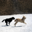

In [ ]:
text_set['train'][0]['image'].resize((32,32))

In [ ]:
x_train[0].shape

(399, 500, 3)

Pretrained transformer

In [ ]:
!pip install transformers
from transformers import AutoImageProcessor, TFAutoModel

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = TFAutoModel.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
inputs = processor(images=x_train[5], return_tensors = 'tf')

In [ ]:
lhs = model(inputs).pooler_output

In [ ]:
lhs.numpy()

(1, 768)

In [ ]:
densed = layers.Dense(2048)(lhs.numpy())

#Import LSTM and Tokenizer, pre-trained with a CSV

In [ ]:
import pickle
clstm = keras.models.load_model('model_8k_9.keras')
tokenizer=''
with open('tokenizer3.pkl', 'rb') as f:
  tokenizer = pickle.load(f)

In [ ]:
clstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 38)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 38, 256)        │      1,762,048 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 38, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 38)             │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ dropout_1[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 6883)           │      1,768,931 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,939,883 (53.18 MB)

 Trainable params: 4,646,627 (17.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,293,256 (35.45 MB)

In [ ]:

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

max_length = 38

def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None
def generate_desc(model, tokenizer, photo, max_length):
  in_text = 'start'
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    pred = model.predict([photo,sequence], verbose=0)
    #print(pred)
    pred = np.argmax(pred)
    word = word_for_id(pred, tokenizer)
    #print(word)
    if word is None:
      break
    in_text += ' ' + word
    if word == 'end':
      break
  return in_text

In [ ]:
densed

<tf.Tensor: shape=(1, 2048), dtype=float32, numpy=
array([[-0.3809901 ,  0.03811603, -0.20798264, ..., -0.02179822,
        -0.6490427 , -0.12854223]], dtype=float32)>

In [ ]:
desc = generate_desc(clstm, tokenizer, densed, max_length)

In [ ]:
print(desc)

start a a a and a black and a dog in the a race end


array([[[236, 214, 173],
        [232, 209, 168],
        [234, 206, 167],
        ...,
        [253, 224, 184],
        [247, 218, 178],
        [240, 211, 171]],

       [[223, 200, 159],
        [232, 207, 167],
        [241, 216, 176],
        ...,
        [250, 227, 186],
        [252, 229, 188],
        [255, 234, 193]],

       [[248, 229, 187],
        [254, 232, 191],
        [255, 239, 196],
        ...,
        [250, 233, 190],
        [250, 235, 192],
        [251, 238, 194]],

       ...,

       [[186, 181, 161],
        [172, 166, 150],
        [160, 153, 143],
        ...,
        [ 98, 111, 130],
        [ 97, 105, 124],
        [105, 112, 130]],

       [[192, 184, 161],
        [179, 172, 153],
        [170, 162, 149],
        ...,
        [ 95, 106, 128],
        [ 86,  97, 117],
        [ 96, 107, 125]],

       [[203, 194, 165],
        [197, 185, 159],
        [179, 173, 159],
        ...,
        [ 78,  90, 114],
        [ 83,  95, 119],
        [ 80,  92, 116]]], dtype=uint8)
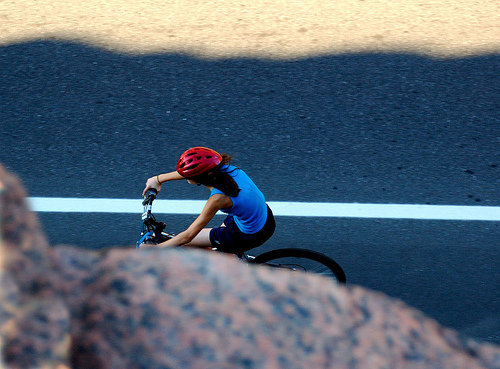

In [ ]:
x_train[5]

#Combining Custom Vision Transformer and LSTM

In [ ]:
from tensorflow import keras

In [ ]:
vit = keras.models.load_model('vit_6.keras', custom_objects = {'ViT': ViT})


/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:730: UserWarning: Model 'vi_t' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
drop_top = keras.Sequential(vit.layers[:-1])

In [ ]:
feature_extractor = keras.Sequential([drop_top, layers.Dense(2048)])

In [ ]:
test_img = np.array(text_set['train'][5]['image'].resize((32,32))).astype('float32')


In [ ]:
features = feature_extractor.predict(test_img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [ ]:
custom_vit_desc = generate_desc(clstm, tokenizer, features, max_length)

In [ ]:
print(custom_vit_desc)

start a dog dog and a white dog end
